## Summary

----

## Imports

In [1]:
import concurrent.futures
import gzip
import os
import shutil
import subprocess
from collections import Counter
from pathlib import Path

import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proteinsolver
import pyarrow as pa
import pyarrow.parquet as pq
from IPython.display import set_matplotlib_formats
from kmbio import PDB
from tqdm.notebook import tqdm

In [2]:
pd.set_option("max_columns", 1000)
pd.set_option("max_rows", 1000)

In [3]:
set_matplotlib_formats("png")

## Parameters

In [4]:
NOTEBOOK_DIR = Path("12_profile_recovery").resolve()
NOTEBOOK_DIR.mkdir(exist_ok =True)

NOTEBOOK_DIR

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/12_profile_recovery')

In [5]:
UNIQUE_ID = "191f05de"

SEQUENCE_GENERATION_METHOD = "expectimax"

In [6]:
DESIGNS_PATH = NOTEBOOK_DIR.parent.joinpath("generate_protein_sequences")
assert DESIGNS_PATH.is_dir()

DESIGNS_PATH

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences')

In [7]:
# 1n5uA03 4z8jA00 4unuA00 4beuA02
STRUCTURE_ID = "4beuA02"

In [8]:
from papermill import execute_notebook


def worker(params):
    input_path = NOTEBOOK_DIR.with_suffix(".ipynb").as_posix()
    output_path = NOTEBOOK_DIR.parent.joinpath(
        NOTEBOOK_DIR.name + f"-{params['STRUCTURE_ID']}.ipynb"
    ).as_posix()
    out = execute_notebook(input_path, output_path, params)
    return out


print(os.getpid())
if os.getpid() == None:
    params_list = [
        {"STRUCTURE_ID": structure_id}
        for structure_id in ["1n5uA03", "4z8jA00", "4unuA00", "4beuA02"]
    ]
    with concurrent.futures.ThreadPoolExecutor(4) as pool:
        futures = pool.map(worker, params_list)
        results = list(futures)

2228368


In [9]:
proteinsolver_stat_dict = {
    "1n5uA03": {
        "map_sequence_identity": 0.41304347826086957,
        "map_proba": 0.42337074875831604,
        "map_logproba": -1.015546441078186,
        "ref_sequence_identity": 1.0,
        "ref_proba": 0.28906363248825073,
        "ref_logproba": -1.9106740951538086,
        "sequence": "KFGERAFKAWAVARLSQRFPKAEFAEVSKLVTDLTKVHTECCHGDLLECADDRADLAKYICENQDSISSKLKECCEKPLLEKSHCIAEVEND",
    },
    "4z8jA00": {
        "map_sequence_identity": 0.4166666666666667,
        "map_proba": 0.48954343795776367,
        "map_logproba": -0.7965440154075623,
        "ref_sequence_identity": 1.0,
        "ref_proba": 0.325325071811676,
        "ref_logproba": -1.840335726737976,
        "sequence": "SPRVVRIVKSESGYGFNVRGQVSEGGQLRSINGELYAPLQHVSAVLPGGAADRAGVRKGDRILEVNGVNVEGATHKQVVDLIRAGEKELILTVLSV",
    },
    "4unuA00": {
        "map_sequence_identity": 0.43119266055045874,
        "map_proba": 0.46164458990097046,
        "map_logproba": -0.8745880126953125,
        "ref_sequence_identity": 1.0,
        "ref_proba": 0.3054293692111969,
        "ref_logproba": -1.7174205780029297,
        "sequence": "SALTQPPSASGSLGQSVTISCTGTSSDVGGYNYVSWYQQHAGKAPKVIIYEVNKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYEGSDNFVFGTGTKVTVL",
    },
    "4beuA02": {
        "map_sequence_identity": 0.41013824884792627,
        "map_proba": 0.5304911136627197,
        "map_logproba": -0.6995142102241516,
        "ref_sequence_identity": 1.0,
        "ref_proba": 0.3164460062980652,
        "ref_logproba": -1.7113533020019531,
        "sequence": "LGQFQSNIEQFKSHMNANTKICAIMKADAYGNGIRGLMPTIIAQGIPCVGVASNAEARAVRESGFKGELIRVRSASLSEMSSALDLNIEELIGTHQQALDLAELAKQSGKTLKVHIALNDGGMGRNGIDMTTEAGKKEAVSIATQPSLSVVGIMTHFPNYNADEVRAKLAQFKESSTWLMQQANLKREEITLHVANSYTALNVPEAQLDMVRPGGVL",
    },
}

proteinsolver_stats = proteinsolver_stat_dict[STRUCTURE_ID]

proteinsolver_stats

{'map_sequence_identity': 0.41013824884792627,
 'map_proba': 0.5304911136627197,
 'map_logproba': -0.6995142102241516,
 'ref_sequence_identity': 1.0,
 'ref_proba': 0.3164460062980652,
 'ref_logproba': -1.7113533020019531,
 'sequence': 'LGQFQSNIEQFKSHMNANTKICAIMKADAYGNGIRGLMPTIIAQGIPCVGVASNAEARAVRESGFKGELIRVRSASLSEMSSALDLNIEELIGTHQQALDLAELAKQSGKTLKVHIALNDGGMGRNGIDMTTEAGKKEAVSIATQPSLSVVGIMTHFPNYNADEVRAKLAQFKESSTWLMQQANLKREEITLHVANSYTALNVPEAQLDMVRPGGVL'}

## Common functions

In [10]:
columns = list("GVALICMFWPDESTYQNKRH")
assert len(columns) == 20
assert len(set(columns)) == 20


def get_sequence_logo_score(sequence, aa_proba_adj):
    return np.mean(
        np.log(aa_proba_adj.values[np.arange(len(sequence)), [columns.index(aa) for aa in sequence]])
    )


def get_sequence_identity(seq1, seq2):
    assert len(seq1) == len(seq2)
    return sum((aa1 == aa2) for aa1, aa2 in zip(seq1, seq2)) / len(seq1)

## Load reference LOGOs

In [11]:
AA_PROBA_ADJ = {}
for rl in [100, 95, 60, 35]:
    AA_PROBA_ADJ[rl] = pq.read_table(
        NOTEBOOK_DIR.parents[2].joinpath(
            "proteinsolver",
            "notebooks",
            "11_profile_recovery",
            f"{STRUCTURE_ID}-rl{rl}-aa-proba-adj.parquet",
        )
    ).to_pandas()

## Load reference structure

In [12]:
STRUCTURE_FILE = Path(proteinsolver.__path__[0]).joinpath("data", "inputs", f"{STRUCTURE_ID}.pdb")
assert STRUCTURE_FILE.is_file()

STRUCTURE_FILE

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/proteinsolver/data/inputs/4beuA02.pdb')

In [13]:
structure = PDB.load(STRUCTURE_FILE)

In [14]:
structure_df = structure.to_dataframe()

## Ingraham

In [15]:
ingraham_data_dir = NOTEBOOK_DIR.parents[2].joinpath(
    "neurips19-graph-protein-design", "notebooks", "03_generate_designs", STRUCTURE_ID
)

!ls {ingraham_data_dir}

coarse	dist  full  hbonds


### Load data

In [16]:
def parse_fasta_file(fin):
    results = []
    row = None
    for line in fin:
        if line.startswith(">"):
            if row is not None:
                results.append(row)
                row = None
            header = [l.strip("> ") for l in line.strip().split(",")]
            if header[0] == "Native":
                row = {
                    "T": None,
                    "sample": -1,
                    "score": float(header[1].replace("score=", "")),
                    "sequence": "",
                }
            else:
                row = {
                    "T": header[0].replace("T=", ""),
                    "sample": header[1].replace("sample=", ""),
                    "score": float(header[2].replace("score=", "")),
                    "sequence": "",
                }
        else:
            row["sequence"] += line.strip()
    if row is not None:
        results.append(row)
    return results

In [17]:
result_dfs = {}
for model_features in ["full", "dist", "coarse", "hbonds"]:
    with gzip.open(
        ingraham_data_dir.joinpath(model_features, "alignments", f"{STRUCTURE_ID}.fa.gz"), "rt"
    ) as fin:
        results = parse_fasta_file(fin)
        results_df = pd.DataFrame(results)
        result_dfs[model_features] = results_df

In [18]:
result_dfs["full"].head()

,T,sample,score,sequence
0,None,-1,1.409763,LGQFQSNIEQFKSHMNANTKICAIMKADAYGNGIRGLMPTIIAQGI...
1,1.0,0,1.825835,ASLLKIRLQNMSSELRMDTRYLIMYKADAKGKGVESLLPSIKCLKW...
2,1.0,1,1.762215,MDGIESALGAFHSKLPDNTQILAVLRATANGRGVASIMPIFAKMNV...
3,1.0,2,1.603048,LGNIRQQLQDFQSQLEEETSISLALKANAHGYGVEKLMPVFIEQNV...
4,1.0,3,2.078782,SEKTRERLETLSRHLADNAFICPQVTPDAFGTGVTGCLPLLQEEKI...


### Calculate scores

In [19]:
# for feature_set in result_dfs:
#     result_dfs[feature_set]["seq_identity"] = list(
#         tqdm(
#             (
#                 get_sequence_identity(sequence, proteinsolver_stats["sequence"])
#                 for sequence in result_dfs[feature_set]["sequence"].values
#             ),
#             total=len(result_dfs[feature_set]),
#         )
#     )

In [20]:
# for feature_set in result_dfs:
#     for rl in AA_PROBA_ADJ:
#         result_dfs[feature_set][f"avg_logprob_{rl}"] = list(
#             tqdm(
#                 (
#                     get_sequence_logo_score(sequence, AA_PROBA_ADJ[rl])
#                     for sequence in result_dfs[feature_set]["sequence"].values
#                 ),
#                 total=len(result_dfs[feature_set]),
#             )
#         )

### Accuracy plot

In [21]:
summary_dfs = {}
for model_features in ["full", "dist", "coarse", "hbonds"]:
    df = pd.read_csv(ingraham_data_dir.joinpath(model_features, "results.csv"))
    df["model_features"] = model_features
    summary_dfs[model_features] = df

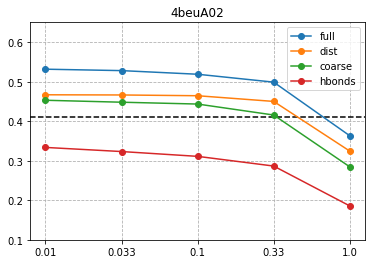

In [22]:
fg, ax = plt.subplots()
for model_features, df in summary_dfs.items():
    x = np.arange(len(df))
    ax.plot(x, df["similarity"], "o-", label=model_features)
    ax.set_xticks(x)
    ax.set_xticklabels(df["T"])
    ax.grid(True, linestyle="--")
    ax.set_ylim(0.1, 0.65)
ax.hlines(proteinsolver_stats["map_sequence_identity"], *ax.set_xlim(), linestyle='--')
ax.legend()
ax.set_title(STRUCTURE_ID)
fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-ingraham-seq-identity.svg"))
fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-ingraham-seq-identity.pdf"))
fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-ingraham-seq-identity.png"), dpi=300)

## Proteinsolver

### Load data

In [24]:
design_files = list(DESIGNS_PATH.glob(f"designs-{UNIQUE_ID}-{SEQUENCE_GENERATION_METHOD}-{STRUCTURE_FILE.stem}-*.parquet"))
design_files[-5:]

[PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-1n5uA03-2044-c02.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-1n5uA03-2012-c02.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-1n5uA03-3028-c02.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-1n5uA03-3099-c02.parquet'),
 PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences/designs-191f05de-expectimax-1n5uA03-1037-c02.parquet')]

In [25]:
dfs = []
for design_file in tqdm(design_files):
    df = pq.read_table(design_file).to_pandas(integer_object_nulls=True)
    dfs.append(df)
proteinsolver_df = pd.concat(dfs, sort=False)

In [26]:
print(len(df))
proteinsolver_df = proteinsolver_df.drop_duplicates(subset=["sequence"])
print(len(df))

5472
5472


### Calculate scores

In [27]:
proteinsolver_df["seq_identity"] = list(
    tqdm(
        (
            get_sequence_identity(sequence, proteinsolver_stats["sequence"])
            for sequence in proteinsolver_df["sequence"].values
        ),
        total=len(proteinsolver_df),
    )
)

In [29]:
for rl in AA_PROBA_ADJ:
    proteinsolver_df[f"avg_logprob_{rl}"] = list(
        tqdm(
            (
                get_sequence_logo_score(sequence, AA_PROBA_ADJ[rl])
                for sequence in proteinsolver_df["sequence"].values
            ),
            total=len(proteinsolver_df),
        )
    )

## Make plots

In [34]:
result_dfs["proteinsolver"] = proteinsolver_df

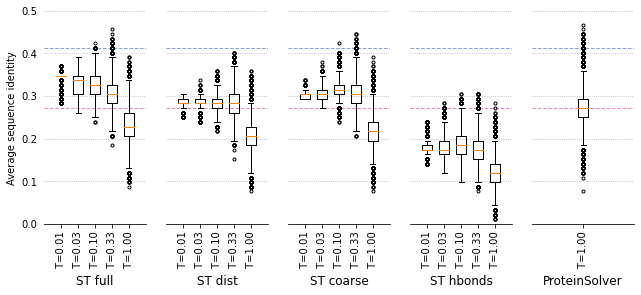

In [57]:
fg, axs = plt.subplots(1, 5, figsize=(9, 4))

ylim = [None, None]
ps_median = None
for i, (featureset, df) in enumerate(result_dfs.items()):
    data = {}
    if featureset in ["proteinsolver"]:
        data["all\ndesigns"] = df["seq_identity"]
    else:
        for temp, gp in df.groupby("T"):
            data[temp] = gp["seq_identity"].values

    ax = axs[i]
    box_values = list(data.values())
    positions = np.linspace(-0.5, 0.5, len(data) + 2)
    width = 0.1
    _ = ax.boxplot(box_values, positions=positions[1:-1], sym=".", widths=width)
    if featureset in ["proteinsolver"]:
        ax.set_xticklabels([f" T=1.00" for key in data.keys()], rotation="vertical")
        ax.set_xlabel(f"ProteinSolver", fontsize="large")
    else:
        ax.set_xticklabels([f" T={float(key):.2f}" for key in data.keys()], rotation="vertical")
        ax.set_xlabel(f"ST {featureset}", fontsize="large")

    ax.set_xlim(positions[0], positions[-1])

    y_min_ = min([v.min() for v in box_values])
    if ylim[0] is None or ylim[0] > y_min_:
        ylim[0] = y_min_
    y_max_ = max([v.max() for v in box_values])
    if ylim[1] is None or ylim[1] < y_max_:
        ylim[1] = y_max_
    if featureset in ["proteinsolver"]:
        ps_median = np.median(box_values[0])

    if i == 0:
        ax.set_ylabel("Average sequence identity")

    if i > 0:
        ax.set_yticklabels("")

    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(axis="y", linestyle=":")

ylim = [ylim[0] * 10 // 1 / 10, np.ceil(ylim[1] * 10) / 10]
for ax in axs:
    ax.set_ylim(ylim)
    ax.hlines(
        proteinsolver_stats["map_sequence_identity"],
        *ax.set_xlim(),
        linestyle="--",
        linewidth=1,
        color=plt.get_cmap("Set2")(2),
    )
    ax.hlines(
        ps_median, *ax.set_xlim(), linestyle="--", linewidth=1, color=plt.get_cmap("Set2")(3),
    )

fg.subplots_adjust(left=0.08, bottom=0.23, top=0.97, right=0.99)
fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-seq-identity.svg"))
fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-seq-identity.pdf"))
fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-seq-identity.png"), dpi=300)

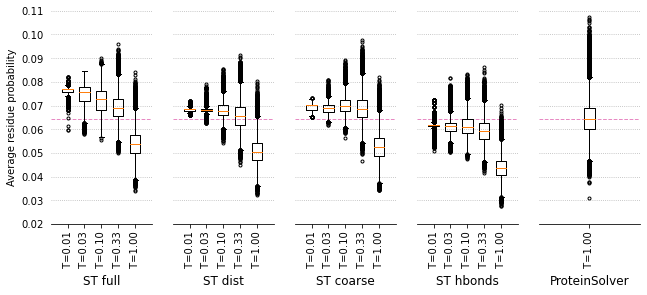

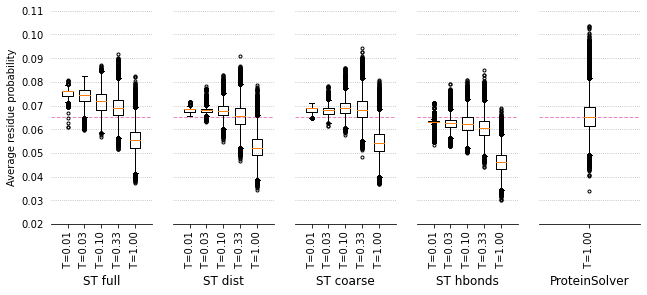

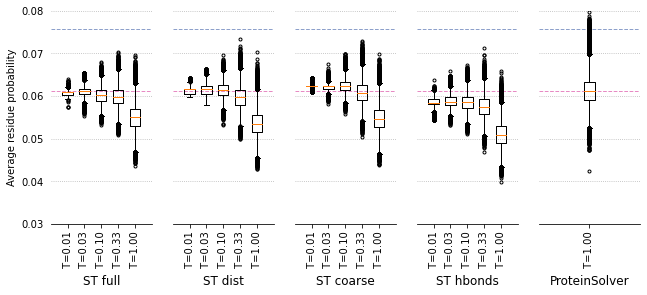

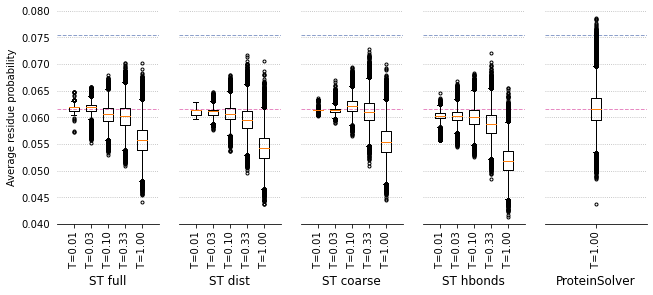

In [58]:
for rl in AA_PROBA_ADJ:
    fg, axs = plt.subplots(1, 5, figsize=(9, 4), constrained_layout=False)

    ylim = [None, None]
    ps_median = None

    for i, (featureset, df) in enumerate(result_dfs.items()):
        data = {}
        if featureset in ["proteinsolver"]:
            data["all\ndesigns"] = np.exp(df[f"avg_logprob_{rl}"].values)
        else:
            for temp, gp in df.groupby("T"):
                data[temp] = np.exp(gp[f"avg_logprob_{rl}"].values)

        ax = axs[i]
        box_values = list(data.values())
        positions = np.linspace(-0.5, 0.5, len(data) + 2)
        width = 0.1
        _ = ax.boxplot(box_values, positions=positions[1:-1], sym=".", widths=width)
        if featureset in ["proteinsolver"]:
            ax.set_xticklabels([f" T=1.00" for key in data.keys()], rotation="vertical")
            ax.set_xlabel(f"ProteinSolver", fontsize="large")
        else:
            ax.set_xticklabels([f" T={float(key):.2f}" for key in data.keys()], rotation="vertical")
            ax.set_xlabel(f"ST {featureset}", fontsize="large")

        ax.set_xlim(positions[0], positions[-1])

        y_min_ = min([v.min() for v in box_values])
        if ylim[0] is None or ylim[0] > y_min_:
            ylim[0] = y_min_
        y_max_ = max([v.max() for v in box_values])
        if ylim[1] is None or ylim[1] < y_max_:
            ylim[1] = y_max_
        if featureset in ["proteinsolver"]:
            ps_median = np.median(box_values[0])

        if i == 0:
            ax.set_ylabel("Average residue probability")

        if i > 0:
            ax.set_yticklabels("")

        for tic in ax.yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.grid(axis="y", linestyle=":")

    ylim = [ylim[0] * 100 // 1 / 100, np.ceil(ylim[1] * 100) / 100]
    for ax in axs:
        ax.set_ylim(ylim)
        ax.hlines(
            np.exp(get_sequence_logo_score(proteinsolver_stats["sequence"], AA_PROBA_ADJ[rl])),
            *ax.set_xlim(),
            linestyle="--",
            linewidth=1,
            color=plt.get_cmap("Set2")(2),
        )
        ax.hlines(
            ps_median, *ax.set_xlim(), linestyle="--", linewidth=1, color=plt.get_cmap("Set2")(3),
        )

    fg.subplots_adjust(left=0.08, bottom=0.23, top=0.97, right=0.99)
    fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-avg-logprog-rl{rl}.svg"))
    fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-avg-logprog-rl{rl}.pdf"))
    fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-avg-logprog-rl{rl}.png"), dpi=300)